<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/Modeltf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install joblib
import tensorflow as tf 
import pickle
from sklearn.externals import joblib
import numpy as np
from tensorflow.python.client import device_lib
from tensorflow.saved_model import simple_save
import random
import matplotlib.pyplot as plt 
import math

from sklearn.model_selection import train_test_split
from tensorflow.python import pywrap_tensorflow


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
from google.colab import drive
drive.mount('/content/drive')


In [0]:
#FEATURES AND LABELS  


with open('/content/features_withITO (1).bin','rb') as file:
  temp = pickle.load(file)
  
  
with open('/content/labels_withITO (2).bin','rb') as file:
  l = pickle.load(file)

In [0]:
features =[]
for i in temp:
  features.append(list(i))

labels=[]  
for i in l:
  labels.append(list(i))

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
## 56 BIT (2253,3147)

# features = joblib.load('/content/features56.pkl')
# labels = joblib.load('/content/labels56.pkl')


In [0]:
## 64 BIT (2253,3147)

# features = joblib.load('/content/features64.pkl')
# labels = joblib.load('/content/labels64.pkl')


In [0]:
# # 32 BIT (2253,1035)

# features = joblib.load('/content/features32.pkl')
# labels = joblib.load('/content/labels32.pkl')

In [0]:
## TEST SET 

x_train_t, x_test_t,y_train_t, y_test_t = train_test_split(features, labels, test_size = 0.3)

In [0]:
tf.reset_default_graph()

In [6]:
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15712975491341417880
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15906666180667990642
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15152431541056782525
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14892338381
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8361973059031989583
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [0]:

from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
model = Sequential()
model.add(Dense(16, input_shape = (9, ), activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.5))
model.add(Dense(1,  activation = 'relu'))

In [0]:
model.compile(optimizer = Adam(lr = 0.001),loss='mse')
model.summary()

In [0]:
hist = model.fit([x_train_t], [y_train_t], validation_split = 0.33, epochs = 1000, verbose = 1, batch_size = 32, shuffle = True)

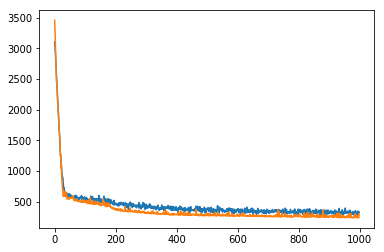

In [32]:
tr = hist.history['loss']
val_ls = hist.history['val_loss']
plt.plot(tr[1:])
plt.plot(val_ls[1:])

In [0]:
predicted = model.predict([x_test_t])


In [0]:
# print(np.shape(y_test_t))
# # print(np.shape(predicted))

actual =[]
pred=[]
se=0
show = np.hstack((y_test_t, predicted))

for i in show:
  se+=(i[0]-i[1])**2
  actual.append(i[0])
  pred.append(i[1])
  
 




In [0]:
rmse = (se/np.size(y_test_t))**0.5

In [36]:
print(rmse)

15.592890611104645


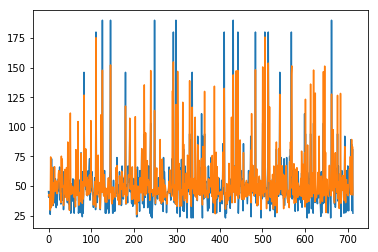

In [0]:
plt.plot(actual)
plt.plot(pred)

In [0]:
print(np.shape(labels))

(2376, 1)


In [0]:
tf.reset_default_graph()

In [0]:
x = tf.placeholder(shape = (None,9), dtype = tf.float32, name = 'input' )
y = tf.placeholder(shape = (None,1), dtype = tf.float32, name = 'target')

#Layer 1 
w1 = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((9, 15)))
b1 = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((1,15)))

# #Layer2 

# w2 = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((15,25)))
# b2 = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((1,25)))

#out

wo = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((15,1)))
bo = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((1,1)))


In [0]:
hidl1 = tf.add(tf.matmul(x,w1),b1, name ='hidden1')

# hidl2 = tf.add(tf.matmul(w1,w2),b2, name = 'hidden2')

In [0]:
outl_batch = tf.compat.v1.layers.batch_normalization(hidl1)
outl = tf.add(tf.matmul(outl_batch,wo),bo,name = 'output')


In [0]:
loss = tf.reduce_mean(tf.square(tf.subtract(y,outl)))

opt = tf.train.AdamOptimizer(name = 'optimizer')
op_train = opt.minimize(loss, name ='train_op')

  

Add additional custom loss functions if necc 
reducing mean sqaure error 
1. reducing max deviation 

In [0]:
saved = tf.train.Saver().as_saver_def()

In [0]:
init = tf.global_variables_initializer()

3672.3103	3331.771
2482.4565	2862.8806
3819.6533	2714.3333
3541.7605	3253.7432
2395.5073	2609.4187
3308.9744	2554.9678
1793.9865	2827.3467
3143.0386	3089.1523
2556.8486	4042.7026
3961.3638	4292.037
2650.1855	2424.7185
3439.2803	6410.3247
3667.6628	2545.2114
3460.6785	2223.69
2595.912	3913.4043
4481.4985	2270.163
2808.0625	3684.4802
2444.105	3601.6052
2304.6091	2991.377
2498.6567	5132.7114
3584.1445	4101.7783
6028.5293	2785.3677
3111.1821	2883.3342
3540.545	3816.144
2901.4087	3630.3252
2695.6343	2746.2021
3699.165	2457.3062
2480.6494	2614.1309
6365.7915	4261.865
2062.0374	2087.2456
2920.4453	3415.878
2528.2283	2920.7231
2253.6443	2963.9827
3354.1013	3510.6575
2370.0652	3908.8813
2324.0498	3676.6536
3525.5166	4061.476
4152.9224	3544.7646
2241.0562	3898.5894
4038.57	2215.4673
4498.6914	4077.6038
2348.9824	2967.5679
2350.9636	3116.9282
3639.3667	2101.1865
2068.1182	2758.9531
3798.1042	3027.8174
2846.9119	3539.141
3785.5283	3427.2493
2517.1545	3086.4849
3647.2507	2745.648
2988.1562	2422.361

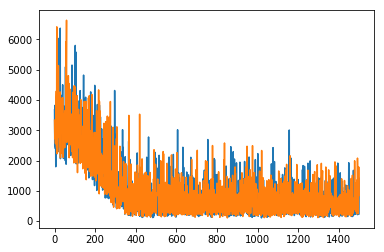

In [21]:
train=[]
val=[]

with tf.device('/device:CPU:0'):
  update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
  save = tf.train.Saver()
  with tf.Session() as sess:
    sess.run(init)
    mini =[]
    for i in range(1500):
      b1=[]
      b2=[]
      l1=[]
      l2=[]
      b1_val=[]
      b2_val=[]
      l1_val=[]
      l2_val=[]
      x_traint, x_test_t,y_traint, y_test_t = train_test_split(features, labels, test_size = 0.3)
      x_trainv, x_testv, y_trainv, y_testv = train_test_split(x_traint, y_traint, test_size = 0.3)
      
      for j in range(16): ##One run is appending 2 random lists 
      #TRAINING MINI BATCHES 
        
        seed = random.choice(range(len(x_trainv)))
        i = random.choice(range(len(x_trainv)))
        
        b1.append(x_trainv[seed])
        b2.append(x_trainv[i])
        l1.append(y_trainv[seed])
        l2.append(y_trainv[i])
        
        x_batch = np.vstack((b1,b2))
        y_batch = np.vstack((l1,l2))
        
        ##VALIDATION MINI BATCHES 
        
        seed_val = random.choice(range(len(x_traint)))
        i_val = random.choice(range(len(x_traint)))
        
        b1_val.append(x_traint[seed_val])
        b2_val.append(x_traint[i_val])
        l1_val.append(y_traint[seed_val])
        l2_val.append(y_traint[i_val])
        
        x_batch_val = np.vstack((b1_val,b2_val))
        y_batch_val = np.vstack((l1_val,l2_val))
      
      ## TRAINING LOSS
      update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
      z= sess.run([loss,op_train, update_ops], feed_dict = {x : x_batch, y: y_batch })
      train.append(z[0])
      
      ##VALIDATION LOSS
      
      z_val= sess.run([loss], feed_dict = {x : x_batch_val, y: y_batch_val })
      val.append(z_val[0])
      
      print(str(z[0]) + '\t' + str(z_val[0]))
    
    plt.plot(train)
    plt.plot(val)
    save_path = save.save(sess, "/content/final_model.ckpt")
    print('Saved model!')
    
 

In [15]:
print(type(tf.get_default_graph().as_graph_def()))
tf.io.write_graph(tf.get_default_graph().as_graph_def(), '/content/', 'final_train.pbtxt')

<class 'tensorflow.core.framework.graph_pb2.GraphDef'>


'/content/final_train.pbtxt'

In [0]:
with open('/content/final_graph.pb', 'wb') as f:
  f.write(tf.get_default_graph().as_graph_def().SerializeToString())
  

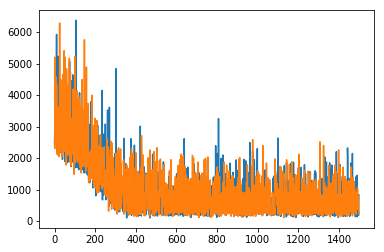

In [17]:
plt.plot(train[1:])
plt.plot(val[1:])

In [27]:
tf.trainable_variables()

[<tf.Variable 'Variable:0' shape=(9, 15) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(1, 15) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(15, 1) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(1, 1) dtype=float32_ref>,
 <tf.Variable 'batch_normalization/gamma:0' shape=(15,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization/beta:0' shape=(15,) dtype=float32_ref>]

In [0]:
## 48 BIT (2253,2315)
'''
features = joblib.load('/content/features48.pkl')
labels = joblib.load('/content/labels48.pkl')
'''

In [0]:
## 16 BIT (2253,267)
'''
features = joblib.load('/content/features16.pkl')
labels = joblib.load('/content/labels16.pkl')
'''